# Get Sensors Reading

## Relevant documents

- (Python Client Repo)[https://github.com/Green-Fusion/energy-management-backend/tree/main/python_client]
- (Swagger UI)[https://control.green-fusion.de/services/energy-management-backend/v1/api/doc#/]


## Inits

In [1]:
#imports
from energy_management_client import BackendPythonClient
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# select your environment
environment="prod" # prod or dev

# Selector
if environment=="dev":
    backend_endpoint_path="https://dev.green-fusion.de/services/energy-management-backend/v1/api"
    realm_type="development"
elif environment=="prod":
    backend_endpoint_path="https://control.green-fusion.de/services/energy-management-backend/v1/api"
    realm_type="control"  
else:
    backend_endpoint_path=""
    realm_type=""
    print("select either prod or dev for the environment")

#test
#backend_endpoint_path, realm_type
if True:
    # pythpon client auth & login
    # init the client   
    client = BackendPythonClient(backend_endpoint=backend_endpoint_path,)
    
    #login
    client.login(
        auth_endpoint="https://auth.green-fusion.de",
        realm=realm_type,
        client_id="backend_python_client", # backend_python_client, datascience_development_api
        grant_type="device_code", #"client_credentials",  # or "password", "device_code"
    )

## Functions

### Sensors readings

In [3]:
def get_chart_data_with_building_str(sensor_ids, start_time, end_time, granularity_in_seconds, client):
    response = client.charts.data(sensor_ids, start_time, end_time, granularity_in_seconds)
    
    sensor_value_dfs = []
    building_id = None

    for sensor_id_str, datapoints in response.sensors.items():
        if not datapoints:
            continue
        
        if building_id is None:
            building_id = str(datapoints[0].building)  # get building from first datapoint
        
        times = [dp.time for dp in datapoints]
        values = [dp.value for dp in datapoints]

        df_values = pd.DataFrame({
            "timestamp": pd.to_datetime(times),
            sensor_id_str: values
        }).set_index("timestamp")

        sensor_value_dfs.append(df_values)

    df_values_combined = pd.concat(sensor_value_dfs, axis=1).sort_index()

    return df_values_combined, building_id
#client.charts.data(sensor_ids,start_time,end_time,granularityInSeconds)

### Sensor infos

## get data

In [4]:
df, buildings = get_chart_data_with_building_str(
    sensor_ids=[11278,11275],
    start_time='2025-06-01T00:00:00',
    end_time='2025-06-30T23:59:00',
    granularity_in_seconds=60,
    client=client
)

In [5]:
buildings

'575'

In [6]:
df.head()

,11275,11278
timestamp,,
2025-06-01 00:00:00+00:00,25.6,2596161
2025-06-01 00:05:00+00:00,25.6,2596161
2025-06-01 00:10:00+00:00,25.6,2596161
2025-06-01 00:15:00+00:00,25.6,2596161
2025-06-01 00:20:00+00:00,25.6,2596161


## Charts

In [7]:
def plot_sensor_data(df, xlim=None, ylim=None):
    sensors = df.columns.tolist()
    n = len(sensors)

    fig, axes = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)

    if n == 1:
        axes = [axes]

    for ax, sensor in zip(axes, sensors):
        ax.plot(df.index, df[sensor], label=f'Sensor {sensor}', color='tab:blue')
        ax.set_ylabel('Value')
        ax.set_title(f'Sensor {sensor}', fontsize=10)
        ax.grid(True)

        # Y-axis limits if provided
        if ylim is not None:
            ax.set_ylim(ylim)

    # X-axis limits if provided
    if xlim is not None:
        axes[-1].set_xlim(xlim)

    # Rotate datetime x-axis ticks
    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

    axes[-1].set_xlabel('Timestamp')
    plt.tight_layout()
    plt.show()

In [11]:
#%matplotlib widget

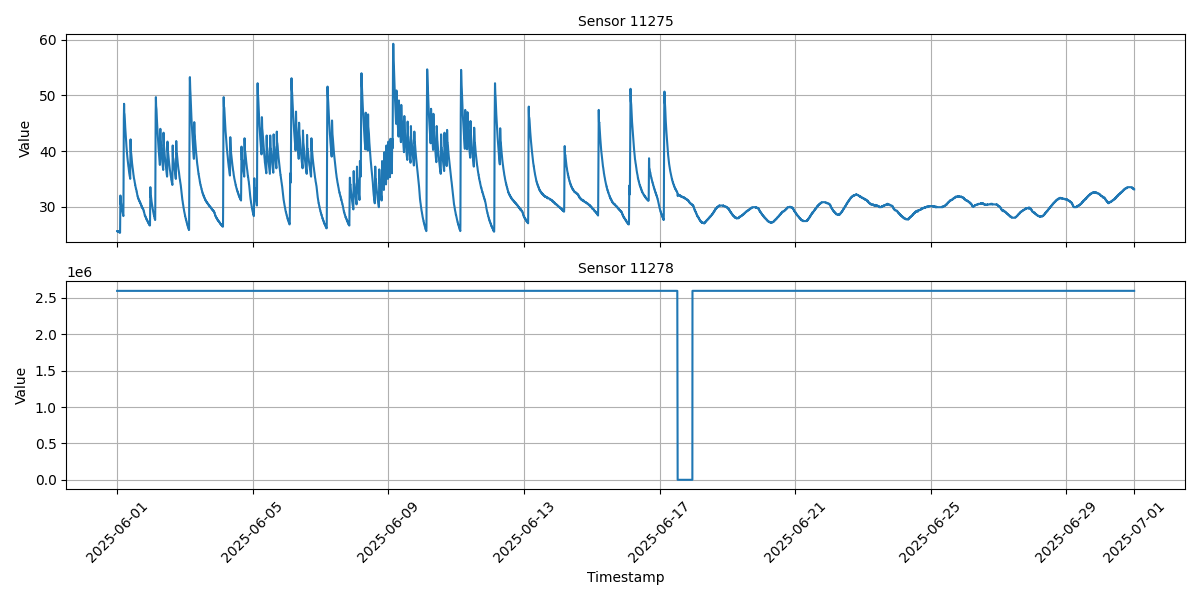

In [13]:
plot_sensor_data(df,xlim=None ) 